In [2]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [3]:
import os
from fastgres.analysis_utility.tools.ring_neighborhood_traversal import RingNeighborhoodTraversal
from fastgres.workloads.workload import Workload
from fastgres.baseline.hint_sets import Hint
from fastgres.baseline.utility import int_to_binary
import random
if os.getcwd() != "C:/Users/Jerome/PycharmProjects/FASTgres":
    os.chdir("C:/Users/Jerome/PycharmProjects/FASTgres")

In [65]:
workload_name = "job"
version = 12.4
a_path = f"fastgres/archives/{workload_name}/{version}/archive.json"
wl_path = f"fastgres/workloads/queries/{workload_name}/"
# wl_path = f"pre_split_queries/stack/context_9"
wl = Workload(wl_path, workload_name)
hints = [hint for hint in Hint]

In [5]:
from fastgres.analysis_utility.tools.hint_set_order import HintSetOrder

# top_k = 5
# config = HintSetOrder.EvaluationConfig(top_k, wl.queries[:50])
# h_o = HintSetOrder(a_path, wl_path, wl.queries, hints)
# h_o.eval_config = config
# h_o.save_results("figures/hint_set_order_vis/test_c0.pdf")
# h_o.show()

In [216]:
h_o = HintSetOrder(a_path, wl_path, wl.queries, hints)
# top_k_values = [1, 2, 3, 4, 5, 10, 20, 50]
reduced_df = h_o.result_df[h_o.result_df["query_name"].isin(h_o.query_names)]
count_aggregate = reduced_df.groupby(by=[f"level_{i}" for i in range(len(h_o.hints) + 1)]).count()
occ = count_aggregate["time_0"].to_numpy()
top_k_values = [i for i in range(1, 100)] + [len(occ)]
# top_k_values.extend([int(0.005*i*len(h_o.query_names)) for i in range(1, 11)])
coverage = []
for top_k in top_k_values:
    config = h_o.EvaluationConfig(top_k, h_o.query_names)
    h_o.eval_config = config
    coverage.append(h_o.get_top_k_results()["coverage"])
# print(top_k_values)
# print(coverage)

[7.4, 14.3, 19.4, 23.7, 27.3, 30.5, 33.5, 36.5, 39.5, 42.2, 44.7, 47.0, 49.2, 51.3, 53.2, 55.1, 56.8, 58.6, 60.3, 62.1, 63.8, 65.3, 66.7, 68.1, 69.4, 70.6, 71.7, 72.8, 73.8, 74.7, 75.6, 76.5, 77.3, 78.1, 78.7, 79.4, 80.0, 80.6, 81.2, 81.7, 82.2, 82.7, 83.2, 83.7, 84.1, 84.5, 84.9, 85.3, 85.7, 86.0, 86.4, 86.7, 87.1, 87.4, 87.7, 88.0, 88.3, 88.6, 88.9, 89.1, 89.3, 89.6, 89.8, 90.1, 90.3, 90.6, 90.8, 91.0, 91.2, 91.4, 91.6, 91.8, 92.0, 92.2, 92.4, 92.6, 92.8, 93.0, 93.2, 93.3, 93.5, 93.6, 93.8, 93.9, 94.1, 94.2, 94.4, 94.5, 94.7, 94.8, 95.0, 95.1, 95.3, 95.4, 95.6, 95.7, 95.9, 96.0, 96.1, 100.0]


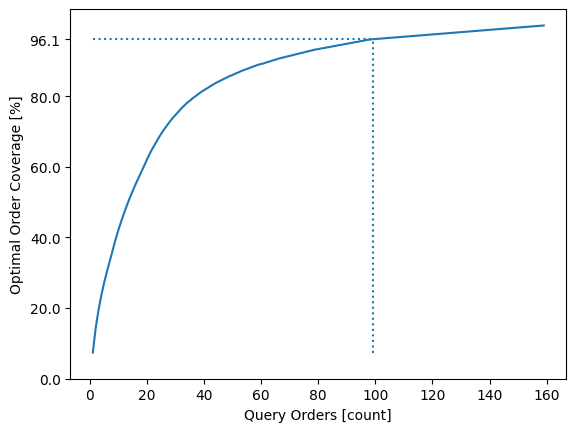

In [217]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.plot(top_k_values, coverage)
ax.set_xlabel("Query Orders [count]")
ax.set_ylabel("Optimal Order Coverage [%]")
ax.vlines(top_k_values[-2], ymin=min(coverage), ymax=coverage[-2], linestyles="dotted")
ax.hlines(coverage[-2], xmin=min(top_k_values), xmax=top_k_values[-2], linestyles="dotted")
new_yticks = ax.get_yticks()
new_yticks = [_ if _ >= 0.0 else 0.0 for _ in new_yticks]
new_yticks = np.array(list((set(new_yticks) - {100., 120.}).union({coverage[-2]})))
ax.set_yticks(new_yticks)
plt.show()

# Optimal Time Deviation

In [219]:
from fastgres.analysis_utility.tools.single_hint_optimization_influence import SingleHintOptimizationInfluence
from fastgres.analysis_utility.tool import TimeGranularity as Tg
from fastgres.analysis_utility import tool

h_o = HintSetOrder(a_path, wl_path, wl.queries, hints, op_mode=RingNeighborhoodTraversal.OperationMode.SUB)
top_k_values = [i for i in range(1, 20)] + [i for i in range(20, 50, 5)] + [i for i in range(50, len(occ), 20)]
sorted_orders = h_o.results["sorted_orders"]

pg_def = [sum(tool.get_baseline(h_o.archive, h_o.query_names)) for _ in top_k_values]
old_opts = default = [sum(tool.get_opt(h_o.archive, h_o.query_names)) for _ in top_k_values]

new_opts = list()
order_size = list()
for top_k in top_k_values:
    order_set = set()
    top_orders = sorted_orders[:top_k]
    for order in top_orders:
        order_set = order_set.union(set(order))
    reduced_archive = tool.get_hint_set_reduced_archive(h_o.archive, list(order_set))
    reduced_archive = tool.get_pseudo_labeled_dict(reduced_archive)
    order_size.append(len(order_set))
    new_opts.append(sum(tool.get_opt(reduced_archive, h_o.query_names)))

old_speedup = tool.get_speedup(pg_def, old_opts)
new_speedup = tool.get_speedup(pg_def, new_opts)
half_index = sum([1 for _ in order_size if _ <= 32]) -1
# print(half_index)
# print(order_size)
# print(old_speedup)
print(new_speedup)


15
[7, 12, 14, 16, 16, 18, 18, 22, 22, 23, 26, 29, 30, 30, 31, 31, 34, 34, 34, 34, 43, 45, 45, 46, 46, 47, 50, 54, 55, 59, 61]
[1.67135636 1.67135636 1.67135636 1.67135636 1.67135636 1.67135636
 1.67135636 1.67135636 1.67135636 1.67135636 1.67135636 1.67135636
 1.67135636 1.67135636 1.67135636 1.67135636 1.67135636 1.67135636
 1.67135636 1.67135636 1.67135636 1.67135636 1.67135636 1.67135636
 1.67135636 1.67135636 1.67135636 1.67135636 1.67135636 1.67135636
 1.67135636]
[1.38081747 1.416172   1.41836848 1.41958655 1.41958655 1.43455571
 1.43455571 1.44604855 1.44604855 1.45693829 1.58506428 1.58546165
 1.58547119 1.58547119 1.58547351 1.58547351 1.58556606 1.58556606
 1.58556606 1.58556606 1.66159302 1.66347047 1.66347047 1.66347047
 1.66347047 1.66798157 1.66862434 1.669792   1.67046676 1.67065795
 1.67126309]


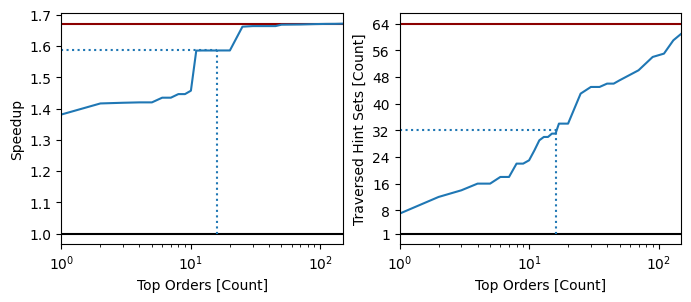

In [220]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].plot(top_k_values, old_speedup, color="darkred")
ax[0].hlines(1.0, min(top_k_values), max(top_k_values), color="black")
ax[0].plot(top_k_values, new_speedup)
ax[0].set_xscale("log")
ax[0].set_xlabel("Top Orders [Count]")
ax[0].set_ylabel("Speedup")
# [ax[0].vlines(i, linestyles="dotted", linewidth=.8, alpha=0.1, ymin=1.0, ymax=max(old_speedup)) for i in top_k_values]
ax[0].set_xlim([min(top_k_values), max(top_k_values)])
ax[0].hlines(new_speedup[half_index], xmin=min(top_k_values), xmax = top_k_values[half_index], linestyles="dotted")
ax[0].vlines(top_k_values[half_index], ymin=1.0, ymax = new_speedup[half_index], linestyles="dotted")

ax[1].plot(top_k_values, order_size)
ax[1].plot(top_k_values, [64 for _ in range(len(order_size))], color="darkred")
ax[1].plot(top_k_values, [1 for _ in range(len(order_size))], color="black")
ax[1].set_xscale("log")
ax[1].set_xlabel("Top Orders [Count]")
ax[1].set_ylabel("Traversed Hint Sets [Count]")
ax[1].set_yticks([1] + [i*8 for i in range(1, 9)])
# [ax[1].vlines(i, linestyles="dotted", linewidth=.8, alpha=0.1, ymin=1, ymax=63) for i in top_k_values]
ax[1].set_xlim([min(top_k_values), max(top_k_values)])
ax[1].hlines(32, xmin=min(top_k_values), xmax = top_k_values[half_index], linestyles="dotted")
ax[1].vlines(top_k_values[half_index], ymin=1.0, ymax = 32, linestyles="dotted")

matplotlib.rcParams['pdf.use14corefonts'] = True
# plt.savefig(f"figures/hint_set_order_vis/order_influence_{workload_name}_c0.pdf", bbox_inches="tight")
plt.show()

# Query Order Traversal

Query not in analysis


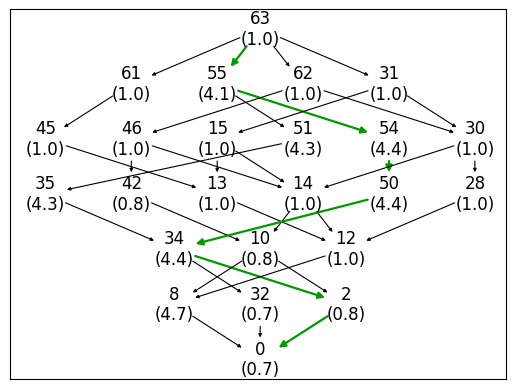

In [71]:
from fastgres.analysis_utility.tools.query_order_traversal import QueryOrderTraversal

q_i = 1
query = wl.queries[q_i:q_i+1]
# query = ["6e.sql"]

factor = 0.1
analysis_queries = wl.queries
random.shuffle(analysis_queries)
analysis_queries = analysis_queries[:int(factor*len(wl.queries))]
try:
    analysis_queries.remove(query)
except ValueError:
    print("Query not in analysis")
    pass

qot = QueryOrderTraversal(a_path, wl_path, analysis_queries, hints, op_mode=QueryOrderTraversal.OperationMode.SUB)
config = QueryOrderTraversal.EvaluationConfig(10, query)
qot.eval_config = config
q_str = str(query[0][:-4][:5])
# qot.save_results(f"figures/hint_set_order_vis/order_influence_{workload_name}_{q_str}.pdf")
qot.show()

# Comparison of FG Default, Heuristic, and Heuristic with Early Stopping

[63, 31, 30, 14, 12, 8, 0]
[63, 31, 30, 15, 14, 10, 12, 8, 4, 0]
[63, 62, 61, 59, 55, 47, 31, 30, 29, 27, 23, 15, 28, 26, 22, 14, 12, 10, 6, 8, 4, 0]


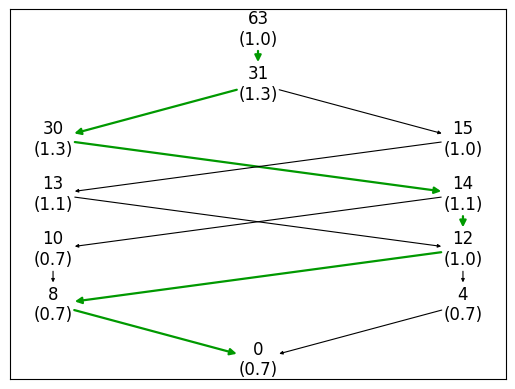

In [86]:
from fastgres.analysis_utility.tools.query_order_traversal import QueryOrderTraversal
from fastgres.analysis_utility import tool
from fastgres.baseline.hint_sets import Hint

# q_i = 1
# query = wl.queries[q_i:q_i+1]
# query = ["6e.sql"]

factor = 0.1
analysis_queries = wl.queries
# random.shuffle(analysis_queries)
analysis_queries = analysis_queries[:int(factor*len(wl.queries))]

remaining_queries = set(wl.queries) - set(analysis_queries)
remaining_queries = list(remaining_queries)
# random.shuffle(remaining_queries)
# query = remaining_queries[q_i:q_i+1]

qot = QueryOrderTraversal(a_path, wl_path, analysis_queries, hints, op_mode=QueryOrderTraversal.OperationMode.SUB)
pg_def = tool.get_baseline(qot._used_dict, remaining_queries)
opt = tool.get_opt(qot._used_dict, remaining_queries)
orders = dict()
for query_name in remaining_queries:
    config = QueryOrderTraversal.EvaluationConfig(3, [query_name])
    qot.eval_config = config
    max_order = list(qot.get_max_order())
    orders[query_name] = qot.get_best_of_order(query_name, max_order)
    print(max_order)
    true_hints = [Hint(_) for _ in tool.get_order_hint_sets(max_order)]
    reduced_space = set()
    for order in qot.get_top_k_results()["orders"]:
        reduced_space = reduced_space.union(set(order))
    reduced_space = list(reduced_space)
    traversed_reduced = qot.calculate_one_ring_of_order(true_hints, reduced_space)
    print(traversed_reduced)
    traversed_full = qot.calculate_one_ring_of_order(true_hints)
    print(traversed_full)
    qot.show()
    break
# q_str = str(query[0][:-4][:5])
# qot.save_results(f"figures/hint_set_order_vis/order_influence_{workload_name}_{q_str}.pdf")
# qot.show()

In [135]:
# import graphviz
# import numpy as np
# 
# # c1 = res["level_1"]==47
# # c2 = res["level_2"]==43
# # print(res[c1 & c2])
# 
# factor = 1.0
# reduced_amount = int(factor*len(wl.queries))
# edge_tuples = set()
# count_aggregate = res.groupby(by=levels).count()
# orders = count_aggregate.index.to_numpy()[:reduced_amount]
# occ = count_aggregate["time_0"].to_numpy()[:reduced_amount]
# 
# # max_ind = np.argmax(np.array(occ))
# # max_orders = [orders[max_ind]]
# # max_order_edges = set()
# # for order_pair in max_orders:
# #     for i in range(1, len(order_pair)):
# #         max_order_edges.add((order_pair[i-1], order_pair[i]))
# # # print(orders)
# # # print(occ)
# # level_uniques = [[63]]
# # for level in range(1, len(hints)+1):
# #     level_uniques.append(list(sorted(set(list(res[f"level_{level}"])), reverse=True)))
# # # print(f"Level uniques: {level_uniques}")
# # 
# # for order_pair in orders:
# #     for i in range(1, len(order_pair)):
# #         edge_tuples.add((order_pair[i-1], order_pair[i]))
# # # print(f"Edge tuples: {edge_tuples}")
# # 
# # d = graphviz.Digraph()
# # for level_idx in range(0, len(hints)+1):
# #     with d.subgraph() as s:
# #         s.attr(rank="same")
# #         [d.node(str(unique)) for unique in level_uniques[level_idx]]
# # 
# # for edge in edge_tuples:
# #     if edge in max_order_edges:
# #         color = "green"
# #         pen_width = "5.0"
# #     else:
# #         color = "black"
# #         pen_width = "1.0"
# #     d.edge(str(edge[0]), str(edge[1]), color=color, penwidth=pen_width)
# # 
# # d.view()
# 
# # occurrence sorted index
# idx = [i for i in range(len(occ))]
# sorted_index_tuples = sorted(list(zip(idx, occ)), key=lambda x: x[1], reverse=True)
# sorted_idx = [_[0] for _ in sorted_index_tuples]
# sorted_occ = [_[1] for _ in sorted_index_tuples]
# sorted_orders = [orders[i] for i in sorted_idx]
# # query_names = list(res["query_name"])
# # sorted_queries = [query_names[i] for i in sorted_idx]
# 
# # threshold based index reduction  
# # threshold_value = 1.0
# # threshold = int(threshold_value*len(wl.queries))
# # threshold_indices = [sorted_idx[i] for i in range(len(sorted_idx)) if sum(sorted_occ[:i]) < threshold]
# 
# # calculation of top-k orders
# perc = 0.10
# top_k = int(perc*len(orders))
# top_k = 5
# top_orders = sorted_orders[:top_k]
# top_occ = sorted_occ[:top_k]
# # top_queries = sorted_queries[:top_k]
# # print(res[res["query_name"].isin(top_queries)])
# # [print(top_queries[i], top_orders[i]) for i in range(len(top_queries))]
# print(f"Max Occurrence: {sum(top_occ)} / {len(wl.queries)}")
# # orders = [orders[i] for i in threshold_indices]
# # occ = [occ[i] for i in threshold_indices]
# 
# # calculate optimal hint set within top k orders
# # top_optimal_hints = set()
# # for query_name in top_queries:
# #     # df line
# #     query_entry = res[res["query_name"]== query_name].to_numpy()[0]
# #     # name, hint sets, times -> 1 : levelsize : levelsize
# #     hint_sets = query_entry[1:len(levels)+1]
# #     hint_set_times = query_entry[len(levels)+1:]
# #     # sort by hint set times to find the optimal solution
# #     sorted_hint_sets = sorted(list(zip(hint_sets, hint_set_times)), key=lambda x: x[1])
# #     # take hint set of minimal values
# #     top_optimal_hints.add(sorted_hint_sets[0][0])
# 
# # query_col = list(res["query_name"])
# # threshold_queries = [query_col[i] for i in sorted_idx[:top_k]]
# # reduced_res = res[res["query_name"].isin(threshold_queries)]
# # reduced_res = reduced_res[reduced_res]
# # min_v = reduced_res.loc[:, times].idxmin(axis=1)
# # min_levels = [int(_[-1]) for _ in list(min_v)]
# # print(reduced_res)
# # min_hints = [reduced_res.iloc[i][f"level_{min_levels[i]}"] for i in range(len(min_levels))]
# # print(min_levels)
# # print(min_hints)
# 
# # calculate top k orders to mark
# top_order_edges = set()
# for order_pair in top_orders:
#     for i in range(1, len(order_pair)):
#         top_order_edges.add((order_pair[i-1], order_pair[i]))
# 
# level_uniques = [[63]]
# for level in range(1, len(hints)+1):
#     single_level_uniques = list(set([order[level] for order in orders]))
#     level_uniques.append(single_level_uniques)
# 
# for order_pair in orders:
#     for i in range(1, len(order_pair)):
#         edge_tuples.add((order_pair[i-1], order_pair[i]))
# 
# d = graphviz.Digraph()
# for level_idx in range(0, len(hints)+1):
#     with d.subgraph() as s:
#         s.attr(rank="same")
#         for unique in level_uniques[level_idx]:
#             d.node(str(unique))
#             # if unique in top_optimal_hints:
#             #     d.node(str(unique), color="red")
#             # else:
#             #     d.node(str(unique))
# 
# for edge in edge_tuples:
#     if edge in top_order_edges:
#         color = "green"
#         pen_width = "5.0"
#     else:
#         color = "black"
#         pen_width = "1.0"
#     d.edge(str(edge[0]), str(edge[1]), color=color, penwidth=pen_width)
# 
# d.view()

In [136]:
# import pandas as pd
# 
# cols = ["query_name"]
# levels = [f"level_{i}" for i in range(len(hints)+1)]
# times = [f"time_{i}" for i in range(len(hints)+1)]
# cols.extend(levels)
# cols.extend(times)
# res = pd.DataFrame(columns=cols)
# traversal = RingNeighborhoodTraversal(a_path, wl_path, [], hints, op_mode=RingNeighborhoodTraversal.OperationMode.SUB, spread=1)
# for query_name in wl.queries:
#     traversal.query_names = [query_name]
#     traversed_hint_sets = traversal.traverse_hint_sets()
#     # order = traversal.traversed_order(traversed_hint_sets)
#     entry = [query_name]
#     entry.extend(list(traversed_hint_sets.keys()))
#     entry.extend(list(traversed_hint_sets.values()))
#     
#     res.loc[len(res.index)] = entry
#     # 
#     # for level_idx in range(1, len(hints)+1):
#     #     key = list(traversed_hint_sets.keys())[level_idx]
#     #     res.loc[len(res.index)] = query_name, level_idx, key, traversed_hint_sets[key]
#     # res[query_name] = {"traversed": traversed_hint_sets, "order": order}
# print(res.head())

In [137]:
# import networkx as nx
# import matplotlib.pyplot as plt
# graph, pos = h_o.plot()
# colors = [graph[u][v]['color'] for u,v in graph.edges()]
# color_map = ['w' for node in graph]
# labels = [str(node) for node in graph]
# weights = [float(graph[u][v]['weight']) for u,v in graph.edges()]
# nx.draw_networkx_nodes(graph, pos=pos, node_color=color_map, label=labels, alpha=0.1, linewidths=0.1)
# nx.draw_networkx_labels(graph, pos)
# index = 0
# for edge in graph.edges(data=True):
#     nx.draw_networkx_edges(graph, pos=pos, edgelist=[(edge[0], edge[1])], edge_color=colors[index], arrowsize=weights[index]*6, width=weights[index])
#     index += 1
# # nx.draw(graph)
# plt.savefig("figures/hint_set_order_vis/test_0.pdf")
# plt.show()